# Projections of Snow Cover Extent
conda env: `phd_v3` (in `envs/phd`)

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Set variables

In [2]:
period_future = slice('2015','2100')
period_past = slice('1979','2014')
latlim, lonlim = u.get_domain_HMA()
# seasons = ['Annual', 'DJFMA', 'JJAS']
seasons = ['Annual']

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

# Get zone limits for annual cycle
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_HK, latlim_HK], [lonlim_HM, latlim_HM], [lonlim_TP, latlim_TP]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

var = 'snc'
table = u.get_table(var)
label, units, levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)
label

'Snow Cover Extent'

## Load topography

In [3]:
ds = xr.open_dataset('GMTED2010_15n240_1000deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

# If no modification possible to load results: [#Load-results](#Load-results)

## Load obs
NOAA Climate Data Record (CDR) of Northern Hemisphere (NH) Snow Cover Extent (SCE), Version 1:
https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc:C00756

In [4]:
obs_longname = 'NOAA Climate Data Record (CDR) Version 1'
obs_name = 'NOAA CDR'

ds_rutger = xr.open_dataset('/data/mlalande/RUTGERS/nhsce_v01r01_19661004_20191202.nc').sel(time=period_past)
with xr.set_options(keep_attrs=True): # Get the snc variable, keep only land data and convert to %
    obs = ds_rutger.snow_cover_extent.where(ds_rutger.land == 1)*100   
obs.attrs['units'] = '%'
obs = obs.rename({'longitude': 'lon', 'latitude': 'lat'}) # Rename lon and lat for the regrid

# Resamble data per month (from per week)
obs = obs.resample(time='1MS').mean('time', skipna=False, keep_attrs=True)

# Check if the time steps are ok
np.testing.assert_equal((int(period_past.stop) - int(period_past.start) + 1)*12, obs.time.size)

# Compute year mean
temp = [None]*len(seasons)

for k, season in enumerate(seasons):
    # Make year_mean
    temp[k] = u.year_mean(obs, calendar='standard', season=season)
    
obs_ym = xr.concat(temp, pd.Index(seasons, name='season'))

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


In [7]:
# obs_clim[2].plot()
# obs_ac
# u.spatial_average(obs_ac).plot()

## Regrid obs towards the elevation grid of 1°x1°
Using xESMF (https://xesmf.readthedocs.io/en/latest/)

In [5]:
# Because obs are not global (https://github.com/JiaweiZhuang/xESMF/issues/15)
import scipy
def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder


regridder = xe.Regridder(obs_ym, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)
obs_ym_regrid = regridder(obs_ym)
obs_ym_regrid.attrs['long_name'] = 'Air Temperature'
obs_ym_regrid.attrs['units'] = units

# Compute annual cycle for each zones
temp = [None]*len(zones)
for i, zone in enumerate(zones):
    temp[i] = u.spatial_average(
        obs_ym_regrid.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
    )

obs_ym_regrid_zones = xr.concat(temp, pd.Index(zones, name="zone")).load()

Reuse existing file: bilinear_88x88_35x60.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


## Load models

In [6]:
list_models = u.get_model_names_projections()
# list_models = list_models[:1]
# list_models = ['EC-Earth3']

resolution = [None]*len(list_models)

da_past_ym_list = [[None] * (len(list_models)) for i in range(len(seasons))]

scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
da_ssp126_ym_list = [[None] * (len(list_models)) for i in range(len(seasons))]
da_ssp245_ym_list = [[None] * (len(list_models)) for i in range(len(seasons))]
da_ssp370_ym_list = [[None] * (len(list_models)) for i in range(len(seasons))]
da_ssp585_ym_list = [[None] * (len(list_models)) for i in range(len(seasons))]

da_future_ym_list = [da_ssp126_ym_list, da_ssp245_ym_list, da_ssp370_ym_list, da_ssp585_ym_list]


for i, model in enumerate(list_models):
    print(model + ' ('+str(i+1)+'/'+str(len(list_models))+')')
    institute, grid, realization, calendar = u.get_model_infos(model, var)
    
    #################
    ### Load past ###
    #################
    da_past = xr.open_mfdataset(
        '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*.nc', 
        combine='by_coords').sel(time=period_past, lat=latlim_ext, lon=lonlim_ext)[var]
    
    np.testing.assert_equal((int(period_past.stop) - int(period_past.start) + 1)*12, da_past.time.size)
    
    # snc (0-1 to % when needed and take out wrong values)
    #################################################################################
    
    # Some models have values between 0 and 1 even if units in %    
    if da_past.max().values <= 1.1:
        da_past = da_past*100
    
    # Some models have wrong values (+-0.1 for numeric precision)
    da_past = da_past.where( (da_past >= -0.1) & (da_past <= 100.1) )
    
    #################################################################################
    
    # Print resolution and save it
    lat = (da_past.lat[1] - da_past.lat[0]).values; lon = (da_past.lon[1] - da_past.lon[0]).values
    print(str(lon.round(3))+'°x'+str(lat.round(3))+'°')
    resolution[i] = str(lon.round(1))+'°x'+str(lat.round(1))+'°'
    
    for k, season in enumerate(seasons):
        # Make year_mean
        da_past_ym = u.year_mean(da_past, calendar=calendar, season=season)

        # Regrid
        regridder = xe.Regridder(da_past, elevation, 'bilinear', periodic=False, reuse_weights=True)
        da_past_ym_regrid = regridder(da_past_ym)

        # Store result
        da_past_ym_list[k][i] = da_past_ym_regrid.load()
    
    
    
    
    ###################
    ### Load future ###
    ###################
    for j, scenario in enumerate(scenarios):
        if model in ['IPSL-CM6A-LR', 'MRI-ESM2-0']:
            da_future = xr.open_mfdataset(
                '/bdd/CMIP6/ScenarioMIP/'+institute+'/'+model+'/'+scenario+'/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*210012.nc', 
                combine='by_coords').sel(time=period_future, lat=latlim_ext, lon=lonlim_ext)[var]
        else:
            da_future = xr.open_mfdataset(
                '/bdd/CMIP6/ScenarioMIP/'+institute+'/'+model+'/'+scenario+'/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*.nc', 
                combine='by_coords').sel(time=period_future, lat=latlim_ext, lon=lonlim_ext)[var]

        np.testing.assert_equal((int(period_future.stop) - int(period_future.start) + 1)*12, da_future.time.size)
        
        # snc (0-1 to % when needed and take out wrong values)
        #################################################################################

        # Some models have values between 0 and 1 even if units in %    
        if da_future.max().values <= 1.1:
            da_future = da_future*100

        # Some models have wrong values (+-0.1 for numeric precision)
        da_future = da_future.where( (da_future >= -0.1) & (da_future <= 100.1) )

        #################################################################################
        
        for k, season in enumerate(seasons):
            # Make year_mean
            da_future_ym = u.year_mean(da_future, calendar=calendar, season=season)

            # Regrid
            da_future_ym_regrid = regridder(da_future_ym)

            # Store result
            da_future_ym_list[j][k][i] = da_future_ym_regrid.load()
        
    print('\n')

BCC-CSM2-MR (1/10)
1.125°x1.121°
Reuse existing file: bilinear_32x54_35x60.nc


CNRM-CM6-1 (2/10)
1.406°x1.401°
Reuse existing file: bilinear_25x42_35x60.nc


CNRM-CM6-1-HR (3/10)
0.5°x0.499°
Reuse existing file: bilinear_70x121_35x60.nc


CNRM-ESM2-1 (4/10)
1.406°x1.401°
Reuse existing file: bilinear_25x42_35x60.nc


CanESM5 (5/10)
2.812°x2.791°
Reuse existing file: bilinear_13x21_35x60.nc


IPSL-CM6A-LR (6/10)
2.5°x1.268°
Reuse existing file: bilinear_28x25_35x60.nc


MIROC-ES2L (7/10)
2.812°x2.791°
Reuse existing file: bilinear_13x21_35x60.nc


MIROC6 (8/10)
1.406°x1.401°
Reuse existing file: bilinear_25x42_35x60.nc


MRI-ESM2-0 (9/10)
1.125°x1.121°
Reuse existing file: bilinear_32x54_35x60.nc


UKESM1-0-LL (10/10)
1.875°x1.25°
Reuse existing file: bilinear_28x32_35x60.nc




In [43]:
'/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/'+grid+'/latest'

'/bdd/CMIP6/CMIP/NCAR/CESM2-WACCM/historical/r1i1p1f1/Amon/pr/gn/latest'

In [46]:
'/bdd/CMIP6/ScenarioMIP/'+institute+'/'+model+'/'+scenario+'/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/'

'/bdd/CMIP6/ScenarioMIP/MPI-M/MPI-ESM1-2-LR/ssp126/r1i1p1f1/Amon/pr/gn/latest/'

## Concatenate results by zones and scenarios

In [7]:
%%time
# Model past
temp = [None]*len(seasons)
for k, season in enumerate(seasons):
    temp[k] = xr.concat(
        da_past_ym_list[k][:], pd.Index(list_models, name='model'), coords='minimal', compat='override'
    )
mm_past_ym = xr.concat(temp, pd.Index(seasons, name="season"))

temp = [None]*len(zones) 
for i, zone in enumerate(zones):
    temp[i] = u.spatial_average(
        mm_past_ym.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
    )
mm_past_ym_zones = xr.concat(temp, pd.Index(zones, name="zone")).load()

CPU times: user 165 ms, sys: 143 ms, total: 308 ms
Wall time: 1.63 s


In [11]:
# mm_past_ym_zones

In [8]:
%%time
# Model future
temp_scenarios = [None]*len(scenarios)

for j, scenario in enumerate(scenarios):
    temp = [None]*len(seasons)
    for k, season in enumerate(seasons):
        temp[k] = xr.concat(
            da_future_ym_list[j][k][:], pd.Index(list_models, name='model'), coords='minimal', compat='override'
        )
    mm_future_ym = xr.concat(temp, pd.Index(seasons, name="season")).load()

    temp = [None]*len(zones) 
    for i, zone in enumerate(zones):
        temp[i] = u.spatial_average(
            mm_future_ym.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
        )
    temp_scenarios[j] = xr.concat(temp, pd.Index(zones, name="zone")).load()
    
mm_future_ym_zones_scenarios = xr.concat(temp_scenarios, pd.Index(scenarios, name="scenario")).load()

CPU times: user 957 ms, sys: 727 ms, total: 1.68 s
Wall time: 6.98 s


In [13]:
# mm_future_ym_zones_scenarios

## Save results

In [18]:
var = 'snc'

In [19]:
var

'snc'

In [20]:
obs_ym_regrid_zones.to_netcdf('results/projections_'+var+'_'+period_past.start+'-'+period_past.start+'_obs_ym_regrid_zones.nc')
mm_past_ym_zones.to_netcdf('results/projections_'+var+'_'+period_past.start+'-'+period_past.start+'_mm_past_ym_zones.nc')
mm_future_ym_zones_scenarios.to_netcdf('results/projections_'+var+'_'+period_future.start+'-'+period_future.start+'_mm_future_ym_zones_scenarios.nc')

## Load results

In [12]:
obs_longname = 'NOAA Climate Data Record (CDR) Version 1'
obs_name = 'NOAA CDR'

list_models = u.get_model_names_projections()
scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']

obs_ym_regrid_zones = xr.open_dataarray('results/projections_'+var+'_'+period_past.start+'-'+period_past.start+'_obs_ym_regrid_zones.nc')
mm_past_ym_zones = xr.open_dataarray('results/projections_'+var+'_'+period_past.start+'-'+period_past.start+'_mm_past_ym_zones.nc')
mm_future_ym_zones_scenarios = xr.open_dataarray('results/projections_'+var+'_'+period_future.start+'-'+period_future.start+'_mm_future_ym_zones_scenarios.nc')

## Plot

## Add custom colors for Boxplot in Proplot
Not implemented yet, see this links for more infos:
- https://github.com/lukelbd/proplot/issues/217
- https://github.com/lukelbd/proplot/pull/218/commits/e34628250e74634ecc25e7f41684b05a2bdb0d30

In [9]:
import matplotlib.patches as mpatches

# https://stackoverflow.com/questions/33371939/calculate-rgb-equivalent-of-base-colors-with-alpha-of-0-5-over-white-background
def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2 for (c1, c2) in zip(rgb, bg_rgb)]

def bbplot_custom_colors(bplot, ax):
    for key, icolor in (('boxes', colors), ('caps', colors), ('whiskers', colors),
                        ('means', colors), ('medians', colors), ('fliers', colors)):
        artists = bplot[key]
        for i, artist in enumerate(artists):
            if key in ['caps', 'whiskers']:
                artist.set_color(icolor[i//2])
                artist.set_markeredgecolor(icolor[i//2])
            elif key not in ['boxes']:
                artist.set_color(icolor[i])
                artist.set_markeredgecolor(icolor[i])
            if key == 'boxes':
                c = make_rgb_transparent(list(plot.colors.to_rgb(icolor[i])), [1, 1, 1], 0.5)
                artist.set_color(c)
                artist.set_markeredgecolor(c)
                patch = mpatches.PathPatch(
                    artist.get_path(), 
                    color=c
                )
                ax.add_artist(patch)

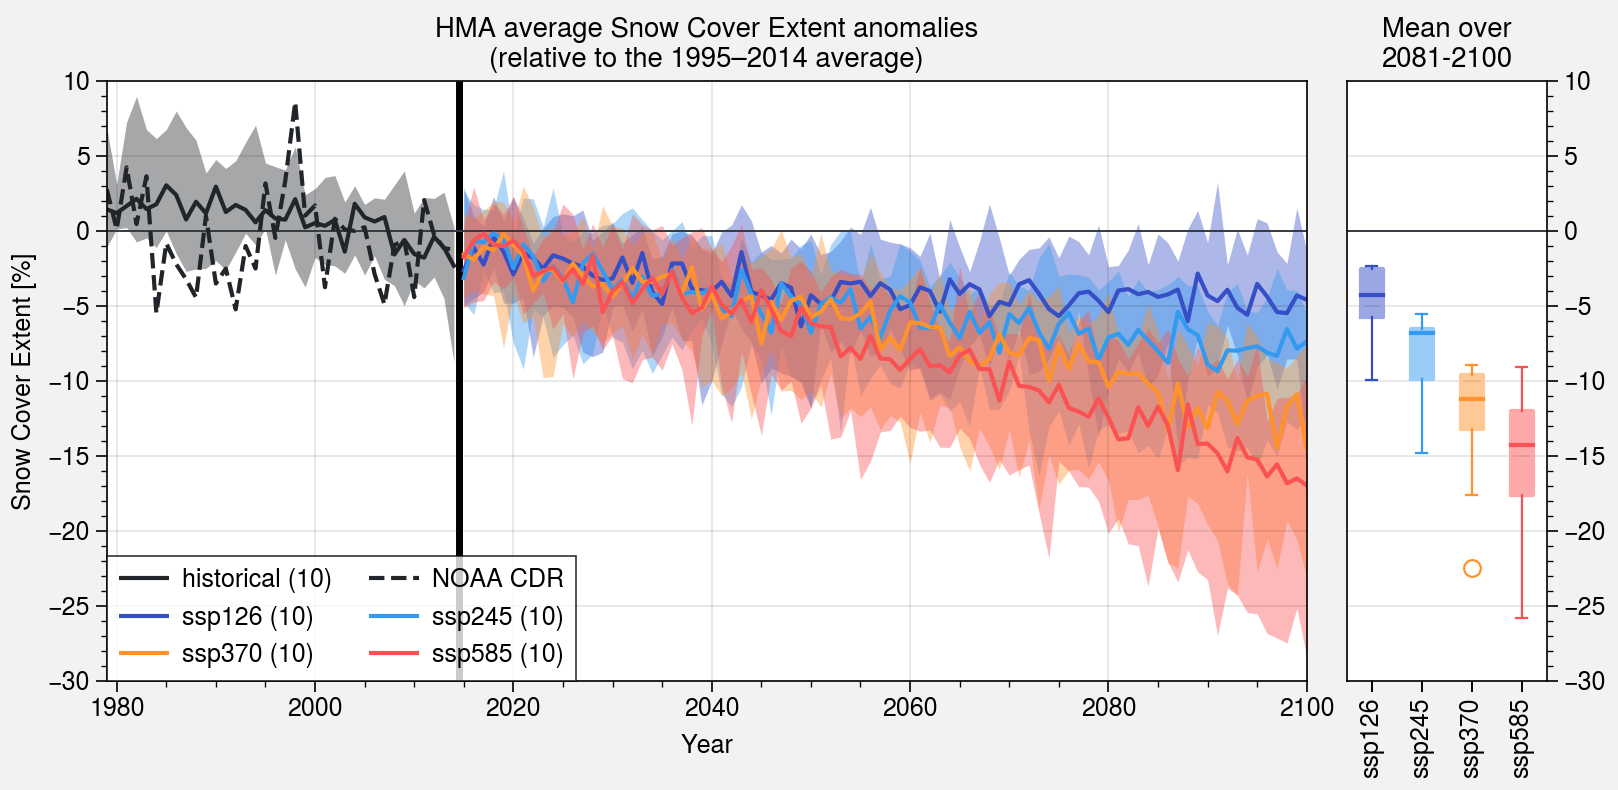

In [14]:
fig, ax = plot.subplots(aspect=2, axwidth=6)

zone = 'HMA'
ymin = -30
ymax = 10

#################################
### Compute the anomalies ###
#################################
clim_models = mm_past_ym_zones.sel(zone=zone, season=seasons[0], year=slice('1995','2014')).mean('year')
anomalies_model = mm_past_ym_zones.sel(zone=zone, season=seasons[0]) - clim_models

clim_obs = obs_ym_regrid_zones.sel(zone=zone, season=seasons[0], year=slice('1995','2014')).mean('year')
anomalies_obs = obs_ym_regrid_zones.sel(zone=zone, season=seasons[0]) - clim_obs

###################
### Models past ###
###################
h_past = ax.plot(
    anomalies_model.median('model'), shadedata=(anomalies_model).quantile([0.05, 0.95], dim='model'), # 90% CI
    label='historical ('+str(len(list_models))+')', color='gray9'
)


###########
### Obs ###
###########
h_obs = ax.plot(
    anomalies_obs, 
    label=obs_name, color='gray9', linestyle='--'
)


#####################
### Models future ###
#####################
colors = ['indigo9', 'blue5', 'orange5', 'red6']
h_future = [None]*len(scenarios)

for i, scenario in enumerate(scenarios):
    anomalies_model_future = mm_future_ym_zones_scenarios.sel(zone=zone, season=seasons[0], scenario=scenario) - clim_models
    
    h_future[i] = ax.plot(
        anomalies_model_future.median('model'), shadedata=(anomalies_model_future).quantile([0.05, 0.95], dim='model'), # 90 % CI
        label=scenario+' ('+str(len(list_models))+')', color=colors[i]
    )


#############
### Panel ###
#############

# Prepare data
data = pd.DataFrame(
    None,
    columns=pd.Index(scenarios, name='scenario')
)
for scenario in scenarios:
    data[scenario] = (mm_future_ym_zones_scenarios.sel(
        zone=zone, season=seasons[0], scenario=scenario, year=slice('2081','2100')).mean('year') - clim_models).values

# Make panel
pax = ax.panel('r', width=1, space=0.2, share=0)

# Plot boxplots
bplot = pax.boxplot(data, medianlw=1.5, boxlw=1.5, showcaps=True)
# Fix bug (or not implement custom colors for boxplots in proplot, see function above)
bbplot_custom_colors(bplot, pax)

# Format
pax.format(
    title='Mean over\n2081-2100', grid=False, ygrid=True, 
    ylocator=5, yminorlocator=1.00001, ylim=(ymin,ymax),
    xrotation=90, 
)


#############
### Lines ###
#############
ax.vlines(2014.5, ymin, ymax, linewidth=2.5)
ax.hlines(0, 1979, 2100, linewidth=0.7, color='gray8')
pax.hlines(0, -0.5, 3.5, linewidth=0.7, color='gray8')
pax.autoscale(enable=True, axis="x", tight=True)


#######################
### Legend / Format ###
#######################
ax.legend(
    [h_past[0], h_obs, h_future[0][0], h_future[1][0], h_future[2][0], h_future[3][0]], 
    loc='ll', frame=True, ncols=2
)

ax.format(
    title='HMA average '+label+' anomalies\n(relative to the 1995–2014 average)', 
    ylabel=label + ' ['+units+']', ylocator=5, yminorlocator=1.00001, ylim=(ymin,ymax),
    xlabel='Year', xminorlocator=5, xlocator=20
)

# fig.save('img/projections/test_projections.jpg')

# All zones plot

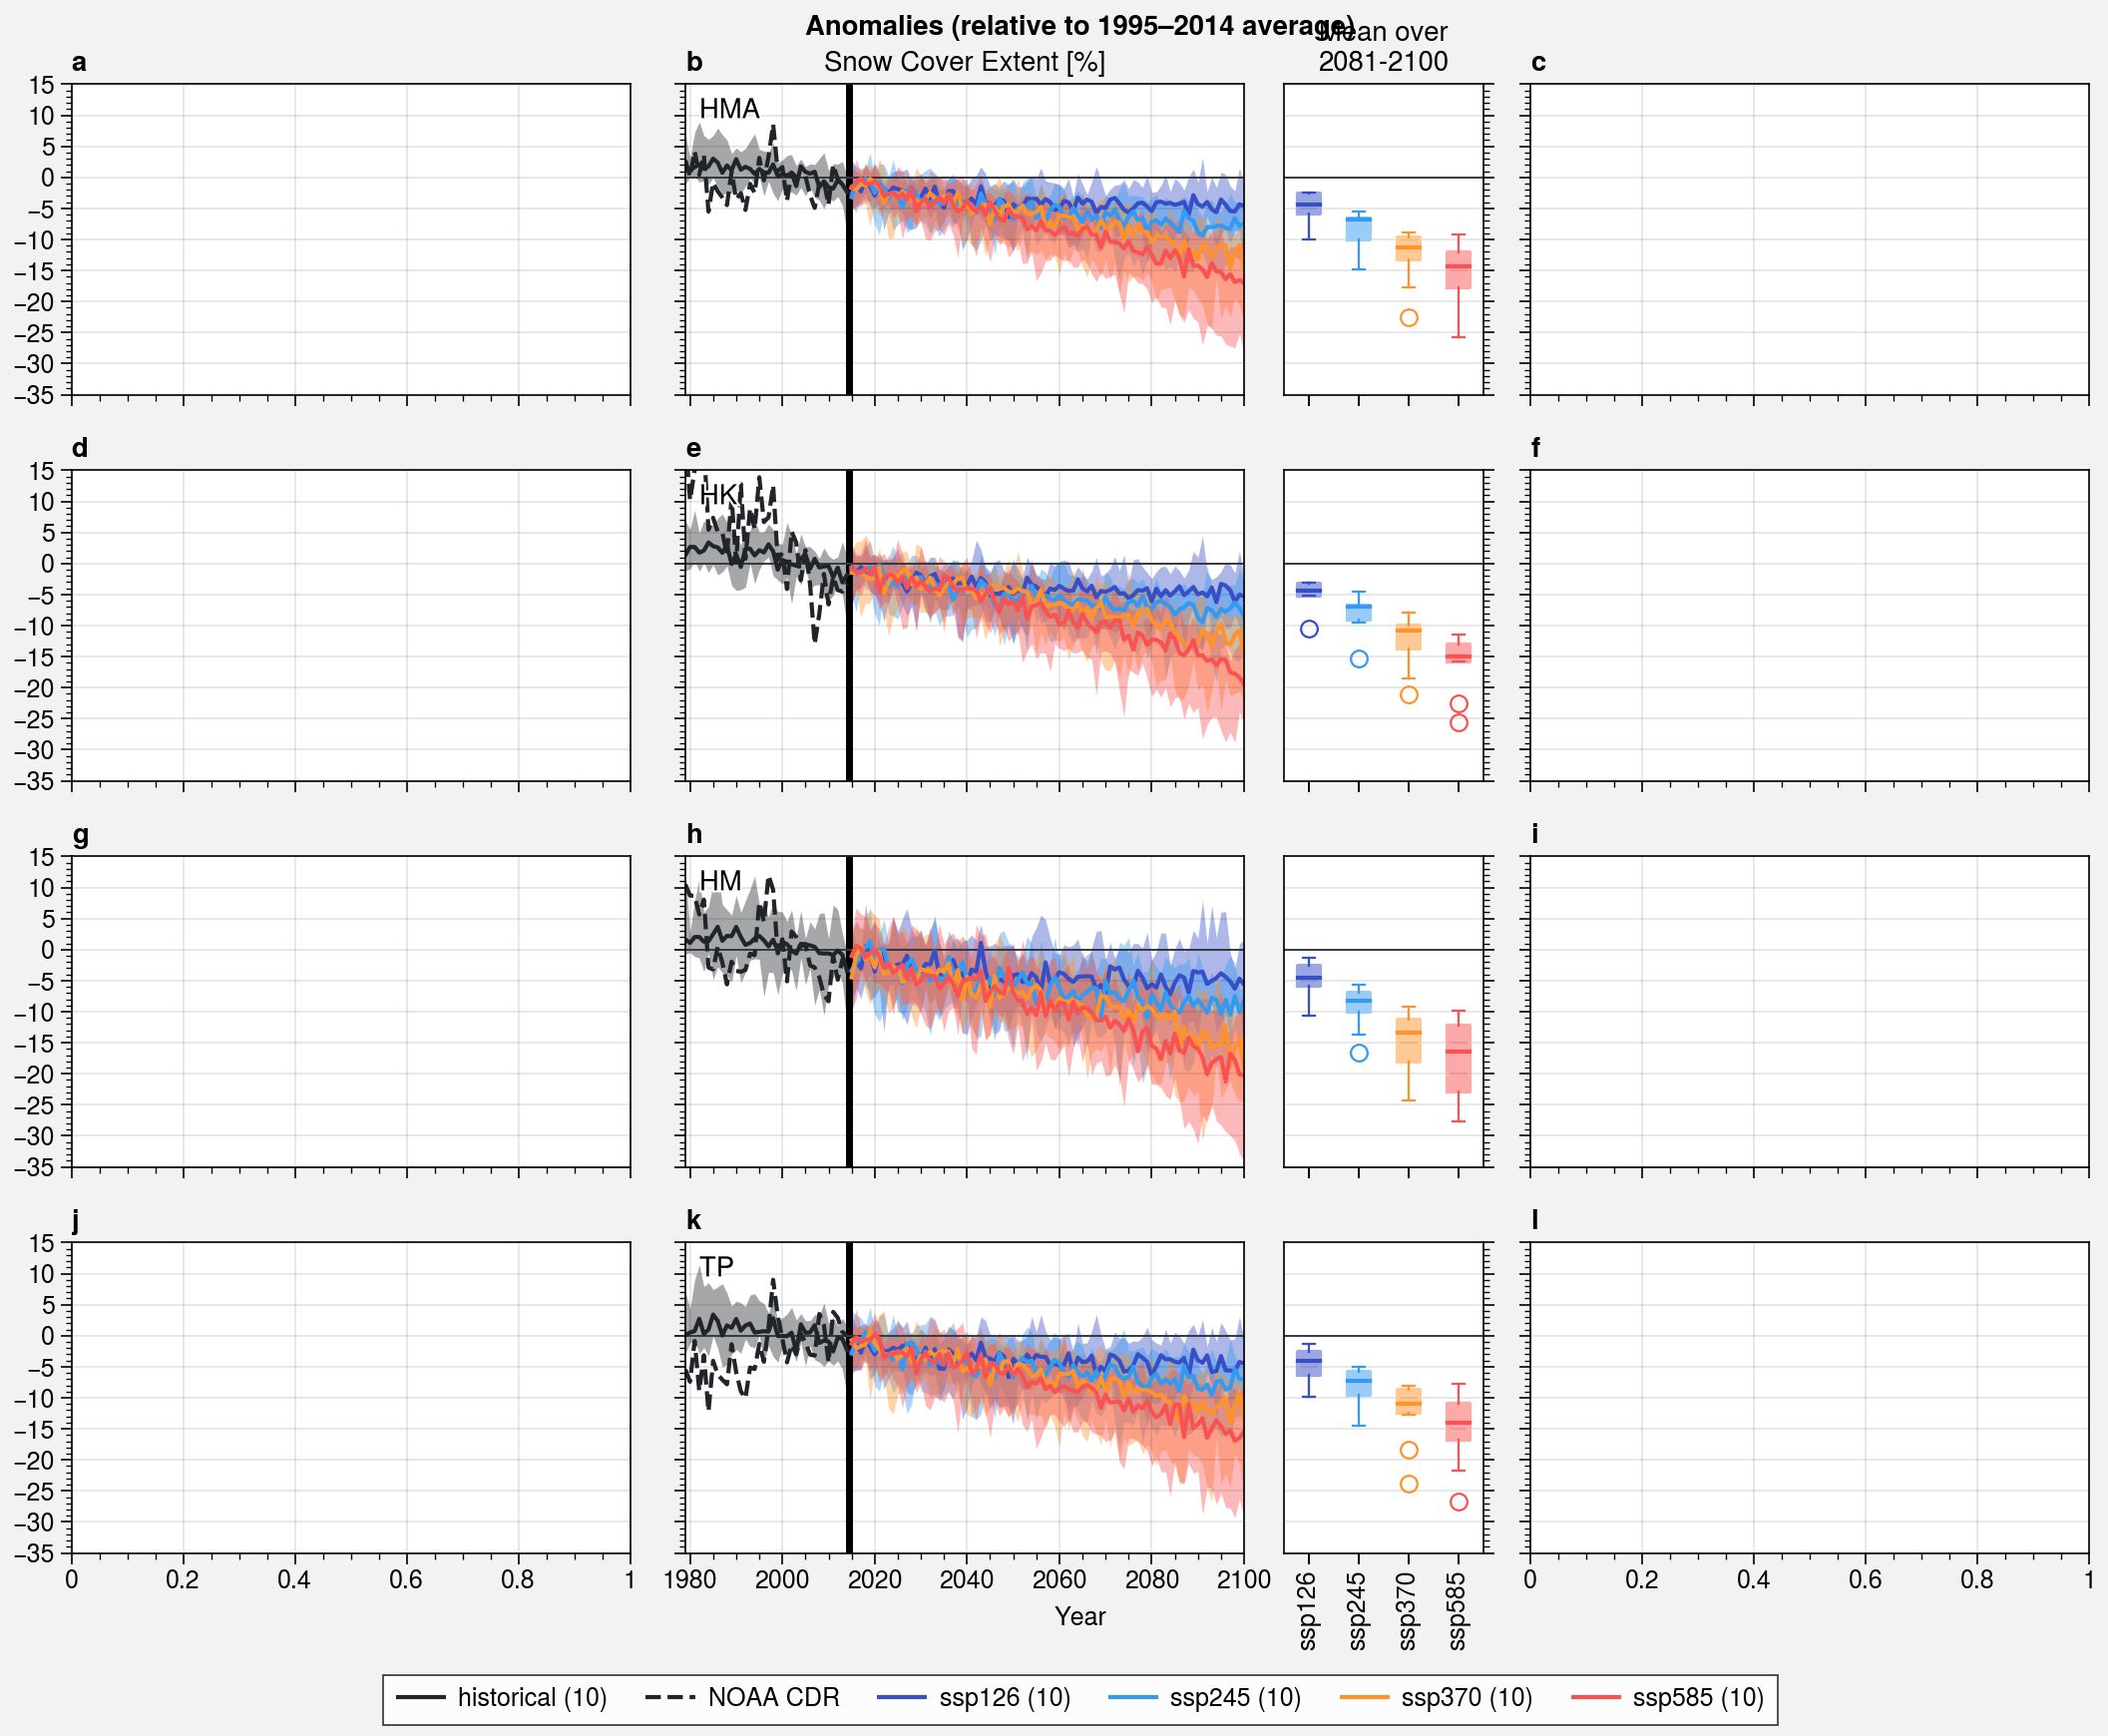

In [16]:
fig, axs = plot.subplots(aspect=1.8, axwidth=2.8, ncols=3, nrows=4)

# cols -> zones
# rows -> variables 

collabels = ['Near-Surface Air Temperature [°C]', 'Snow Cover Extent [%]', 'Total Precipitation [mm/day]']

k = 0
for zone in zones:
# zone = 'HMA'
# ymin = -4.5
# ymax = 11
    for var in ['tas', 'snc', 'pr']:

        if var == 'snc':
            ymin = -35
            ymax = 15
            
            #################################
            ### Compute the anomalies ###
            #################################
            clim_models = mm_past_ym_zones.sel(zone=zone, season=seasons[0], year=slice('1995','2014')).mean('year')
            anomalies_model = mm_past_ym_zones.sel(zone=zone, season=seasons[0]) - clim_models

            clim_obs = obs_ym_regrid_zones.sel(zone=zone, season=seasons[0], year=slice('1995','2014')).mean('year')
            anomalies_obs = obs_ym_regrid_zones.sel(zone=zone, season=seasons[0]) - clim_obs

            ###################
            ### Models past ###
            ###################
            h_past = axs[k].plot(
                anomalies_model.median('model'), shadedata=(anomalies_model).quantile([0.05, 0.95], dim='model'), # 90% CI
                label='historical ('+str(len(list_models))+')', color='gray9'
            )


            ###########
            ### Obs ###
            ###########
            h_obs = axs[k].plot(
                anomalies_obs, 
                label=obs_name, color='gray9', linestyle='--'
            )


            #####################
            ### Models future ###
            #####################
            colors = ['indigo9', 'blue5', 'orange5', 'red6']
            h_future = [None]*len(scenarios)

            for i, scenario in enumerate(scenarios):
                anomalies_model_future = mm_future_ym_zones_scenarios.sel(zone=zone, season=seasons[0], scenario=scenario) - clim_models

                h_future[i] = axs[k].plot(
                    anomalies_model_future.median('model'), shadedata=(anomalies_model_future).quantile([0.05, 0.95], dim='model'), # 90 % CI
                    label=scenario+' ('+str(len(list_models))+')', color=colors[i]
                )


            #############
            ### Panel ###
            #############

            # Prepare data
            data = pd.DataFrame(
                None,
                columns=pd.Index(scenarios, name='scenario')
            )
            for scenario in scenarios:
                data[scenario] = (mm_future_ym_zones_scenarios.sel(
                    zone=zone, season=seasons[0], scenario=scenario, year=slice('2081','2100')).mean('year') - clim_models).values

            # Make panel
            pax = axs[k].panel('r', width=1, space=0.2, share=0)

            # Plot boxplots
            bplot = pax.boxplot(data, medianlw=1.5, boxlw=1.5, showcaps=True)
            # Fix bug (or not implement custom colors for boxplots in proplot, see function above)
            bbplot_custom_colors(bplot, pax)

            # Format
            pax.format(
                grid=False, ygrid=True, 
                ylocator=5, yminorlocator=1.00001, ylim=(ymin,ymax),
                xrotation=90, 
            )
            
            if k in [0, 1, 2]:
                pax.format(
                    title='Mean over\n2081-2100'
                )

            #############
            ### Lines ###
            #############
            axs[k].vlines(2014.5, ymin, ymax, linewidth=2.5)
            axs[k].hlines(0, 1979, 2100, linewidth=0.7, color='gray8')
            pax.hlines(0, -0.5, 3.5, linewidth=0.7, color='gray8')
            pax.autoscale(enable=True, axis="x", tight=True)


            ##############
            ### Format ###
            ##############
            axs[k].format(
                ultitle=zone,
                title='', 
                ylabel='', ylocator=5, yminorlocator=1.00001, ylim=(ymin,ymax),
                xlabel='Year', xminorlocator=5, xlocator=20
            )
            
            if k in [0, 1, 2]:
                axs[k].format(
                    title=collabels[k], 
                    ylabel='', ylocator=5, yminorlocator=1.00001, ylim=(ymin,ymax),
                    xlabel='Year', xminorlocator=5, xlocator=20
                )
        
        k += 1
        
axs.format(
    suptitle='Anomalies (relative to 1995–2014 average)',
    abc=True
)

##############
### Legend ###
##############
fig.legend(
    [h_past[0], h_obs, h_future[0][0], h_future[1][0], h_future[2][0], h_future[3][0]], 
    loc='b', frame=True, ncols=6
)

# fig.save('img/projections/test_projections.jpg')